# 11. Syntax 2 — Lab solutions

### Introduction

This is a continuation of the [previous laboratory notebook](../10_Syntax/10_Syntax_lab_1.ipynb). If you haven't solved all exercises in it (especially [exercise 4](../10_Syntax/10_Syntax_lab_1.ipynb#4.-Treebanks), please start with that.

Also, since exercises 1 and 2 are similar, I suggest once you solve one of them, you follow up with exercise 3. You can go back to the other one after that.

### Boilerplate

The following code imports the packages we are going to use. It also defines a function that draws the parse trees with the [`Graphviz`](http://www.graphviz.org/) library. `nltk` _can_ display the trees, but it depends on Tcl, which doesn't work on a headless (GUI-less) system.

In [1]:
import graphviz
import nltk
from nltk import Nonterminal
from nltk.parse.generate import generate
from nltk.tree import Tree

def does_tcl_work():
    """Checks if Tcl is installed and works (e.g. it won't on a headless server)."""
    tree = nltk.tree.Tree('test', [])
    try:
        tree._repr_png_()
        return True
    except:
        return False

def draw_tree(tree):
    """Draws an NLTK parse tree via Graphviz."""
    def draw_tree_rec(curr_root, graph, last_node):
        node_id = str(int(last_node) + 1)
        for child in curr_root:
            if isinstance(child, nltk.tree.Tree):
                graph.node(node_id, child.label(), penwidth='0')
                graph.edge(last_node, node_id, color='darkslategray3', style='bold')
                node_id = draw_tree_rec(child, graph, node_id)
            else:
                graph.node(node_id, child, penwidth='0')
                graph.edge(last_node, node_id, color='darkslategray3', style='bold')
        return str(int(node_id) + 1)
    
    graph = graphviz.Graph()
    graph.graph_attr['ranksep'] = '0.2'
    graph.node('0', tree.label(), penwidth='0')
    draw_tree_rec(tree, graph, '0')
    return graph._repr_svg_()

# Use Graphviz to draw the tree if the Tcl backend of nltk doesn't work
if not does_tcl_work():
    svg_formatter = get_ipython().display_formatter.formatters['image/svg+xml']
    svg_formatter.for_type(nltk.tree.Tree, draw_tree)
    # Delete the nltk drawing function, just to be sure
    if hasattr(Tree, '_repr_png_'):
        delattr(Tree, '_repr_png_')

### Grammar

Yet again, we are going to work with our toy grammar from last time.

In [2]:
toy_grammar = nltk.CFG.fromstring("""
S -> NP VP
NP -> Pronoun | ProperNoun | Det Nominal
Nominal -> Nominal Noun
Nominal -> Noun
VP -> Verb | Verb PP | Verb NP | Verb NP PP | Verb NP NP | Verb NP NP PP
PP -> Preposition NP
Pronoun -> 'he' | 'she' | 'him' | 'her'
ProperNoun -> 'John' | 'Mary' | 'Fido'
Det -> 'a' | 'an' | 'the'
Noun -> 'flower' | 'bone' | 'necklace' | 'dream' | 'hole' | 'café' | 'house' | 'bed'
Verb -> 'loves' | 'gives' | 'gave' | 'sleeps' | 'digs' | 'dag' | 'ate'
Preposition -> 'in' | 'on' | 'behind'
""")

toy_parser = nltk.ChartParser(toy_grammar)

### 1. CNF $-$ unit productions

As you saw last time, NLTK can only convert parse trees to the Chomsky Normal Forms, not grammars. In the first two exercises, we are going to rectify this omission.

#### 1.1 Enumerate all unit productions in a grammar

As a warm-up exercise, write a function that
- takes a grammar as its argument
- returns all unit production rules from it ...
- ... as a generator (i.e. returns an iterator, not a `list`)

Note that "lexicon" rules (where the right hand side is a single **terminal**) are not considered unit productions. A unit production is a rule of the form **nonterminal$\rightarrow$nonterminal**, such as `NP`$\rightarrow$`ProperNoun`.

The [API you will have to use](http://www.nltk.org/api/nltk.html#module-nltk.grammar):
1. The productions of a grammar can be listed with its [`productions()`](http://www.nltk.org/api/nltk.html#nltk.grammar.CFG.productions) method
1. Note that `productions()` returns the actual production list -- **do not modify it in place**, if you want to keep the grammar intact!
1. Each returned item is a [`Production`](http://www.nltk.org/api/nltk.html#nltk.grammar.Production), which consists of
  - a left hand side (`lhs()`): a [`Nonterminal`](http://www.nltk.org/api/nltk.html#nltk.grammar.Nonterminal)
  - a right hand side (`rhs()`): a tuple of `Nonterminal`s and terminals (strings)
1. Generally, in the `nlkt.grammar` API, nonterminals are `Nonterminal`s and terminals are strings
1. It is also possible to call `productions()` with the `lhs` argument to "search" for rules that have the specified nonterminal on their left hand side. However, keep in mind that you have to give it a `Nonterminal` object for the reason given above.

In [3]:
def unit_productions(grammar):
    for p in grammar.productions():
        if len(p.rhs()) == 1 and isinstance(p.rhs()[0], Nonterminal):
            yield p

assert len(list(unit_productions(toy_grammar))) == 4

#### 1.2 Re-implement `collapse_unary`

`nltk.tree.Tree` has the [`collapse_unary`](http://www.nltk.org/api/nltk.html#nltk.tree.Tree.collapse_unary) function, which eliminates unit productions in parse trees. Implement a similar function that takes a grammar instead, and transforms it the same way. The function should return a **new grammar**; keeping the original grammar intact will make testing much easier.

As the first exercise, implement the algorithm as we learned during [the lecture](../09_Syntax/09_Syntax_lecture_1.pdf) (feel free to run through the algorithm again $-$ it starts on page 35 / slide 115). As a reminder, when you find a unit production rule, e.g. `NP`$\rightarrow$`ProperNoun`, you
- first delete that rule
- "pull up" the right hand side (`ProperNoun`) in place of the left hand side (`NP`) into each rule where the LHS occurs on the right, e.g. given `S`$\rightarrow$`NP VP` you should also create the new rule `S`$\rightarrow$`ProperNoun VP`.

You can use the sentence _John gave Mary a flower in the café_ to test your algorithm. However, do test you algorithm with other sentences as well.

**Note**:

1. You can create a new grammar with the constructor [`nltk.grammar.CFG(start, productions)`](http://www.nltk.org/api/nltk.html#nltk.grammar.CFG).
1. Your function should probably call `unit_productions()` first to see which rules it needs to handle.
1. It might also be a good idea to get rid of the unit production rules one-by-one (just like in the lecture slides), instead of trying to handle all at the same time.
1. It is easiest if you just work with the production list and forget about the `CFG` object. You can create one to encapsulate your productions in the `return` statement.
1. Don't forget that a rule can contain a symbol more than once; see `VP` $\rightarrow$ `Verb NP NP`. When replacing `NP` with `ProperNoun`, you should end up with 4 versions of this rule:
    - `VP` $\rightarrow$ `Verb NP NP`
    - `VP` $\rightarrow$ `Verb ProperNoun NP`
    - `VP` $\rightarrow$ `Verb NP ProperNoun`
    - `VP` $\rightarrow$ `Verb ProperNoun ProperNoun`    
1. You can use the two helper methods provided below to deal with this latter problem.

In [4]:
from itertools import chain, combinations

from nltk.grammar import Production, CFG

def rhs_indices(rhs, nt):
    """Returns the positions the nonterminal nt occurs in rhs."""
    indices = []
    for index, symbol in enumerate(rhs):
        if symbol == nt:
            indices.append(index)
    return indices

def powerset(iterable):
    """An itertools recipe."""
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def collapse_unary_vanilla(grammar):
    units = unit_productions(grammar)
    productions = grammar.productions()
    for unit in units:
        new_productions = []
        for production in productions:
            if production == unit:
                continue
            indices = rhs_indices(production.rhs(), unit.lhs())
            for index_set in powerset(indices):
                new_rhs = list(production.rhs())
                for index in index_set:
                    new_rhs[index] = unit.rhs()[0]
                new_productions.append(Production(production.lhs(), tuple(new_rhs)))
        productions = new_productions
    return CFG(grammar.start(), productions)

new_grammar = collapse_unary_vanilla(toy_grammar)
assert len(new_grammar.productions()) == 66

#### 1.3 Follow NLTK naming convention

Note that while the algorithm behind `collapse_unary` is the same as what you have just implemented, `collapse_unary` also **renames** the nonterminals that were "pulled up". 

See how the `NP`$\rightarrow$`ProperNoun` unit production rule was handled in the example below. Modify your algorithm so that it also renames the nonterminals in the same way.

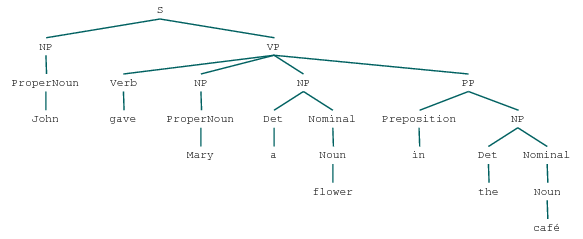

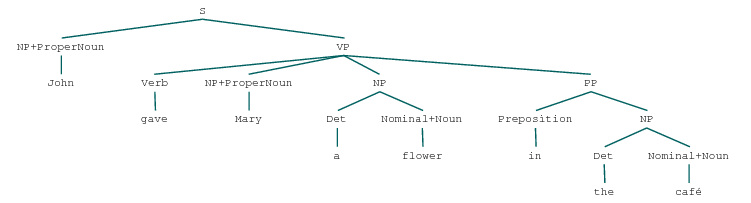

In [5]:
# Example call to tree.collapse_unary() to see how the names of nonterminals change
for tree in toy_parser.parse('John gave Mary a flower in the café'.split()):
    display(tree)
    tree.collapse_unary(collapsePOS=True)
    display(tree)

In [ ]:
def collapse_unary(grammar):
    # Your solution here
    pass

### 2 CNF $-$ too long RHS

Continuing the work we started in exercise 1, we now target rules whose right hand side is too long $-$ i.e. it contains more than two symbols.

#### 2.1 Enumerate all rules with too long RHS

Again, as a warm-up exercise, write a function that
- takes a grammar as its argument
- returns rules with too long RHS ...
- ... as a generator (i.e. returns an iterator, not a `list`)

In [6]:
def too_long_rhs(grammar):
    for p in grammar.productions():
        if len(p.rhs()) > 2:
            yield p

assert len(list(too_long_rhs(toy_grammar))) == 3

#### 2.2 Re-implement `chomsky_normal_form`

`nltk.tree.Tree` has the [`chomsky_normal_form`](http://www.nltk.org/api/nltk.html#nltk.tree.Tree.chomsky_normal_form) function, which eliminates rules with too long RHS. Implement a similar function that takes a grammar instead, and transforms it the same way. The function should return a **new grammar**; keeping the original grammar intact will make testing much easier.

As the first exercise, implement the algorithm as we learned during [the lecture](../09_Syntax/09_Syntax_lecture_1.pdf) (feel free to run through the algorithm again $-$ it starts on page 34 / slide 113). As a reminder, when you find such a rule, e.g. `VP` $\rightarrow$ `Verb NP PP`, you
- introduce a new nonterminal (e.g. `VP_`)
- split the original rule into two:
    - keep only the first symbol on the RHS and add the new nonterminal to it: `VP` $\rightarrow$ `Verb VP_`
    - add a new rule in which the new nonterminal generates the symbols it replaced: `VP_` $\rightarrow$ `NP PP`

Make sure that
- the rule transformation is recursive, so that you can handle arbirarily long right hand sides (e.g. the rule `VP` $\rightarrow$ `Verb NP NP PP`).
- you come up with a naming scheme that ensures all new nonterminals have unique names. E.g. you cannot name the new intermediate nonterminal `VP_` for both `VP` $\rightarrow$ `Verb NP NP` and `VP` $\rightarrow$ `Verb NP PP`, because that would mix the derivation for the original two rules. One idea to avoid this is to maintain a count of how many new non-terminals you introduced and include it in the name, so you would end up with `VP_1`, `VP_2`, `NP_3`, etc.

In [7]:
def chomsky_normal_form_vanilla(grammar):
    mod_rule = 0
    new_productions = []
    for rule in grammar.productions():
        orig_lhs = rule.lhs().symbol()
        while len(rule.rhs()) > 2:
            mod_rule += 1
            new_nt = Nonterminal('{}_{}'.format(orig_lhs, mod_rule))
            new_productions.append(Production(rule.lhs(), (rule.rhs()[0], new_nt)))
            rule = Production(new_nt, rule.rhs()[1:])
        new_productions.append(rule)
    return CFG(grammar.start(), new_productions)

new_grammar = chomsky_normal_form_vanilla(toy_grammar)
assert len(new_grammar.productions()) == 45

#### 2.3 Follow NLTK naming convention

Note that while the algorithm behind `chomsky_normal_form` is the same as what you have just implemented, the names of the new nonterminals follow a very specific pattern. 

See how the `VP` $\rightarrow$ `Verb NP PP` rule was handled in the example below. Modify your algorithm so that it also renames the nonterminals in the same way.

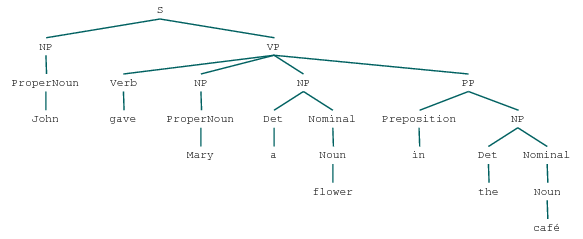

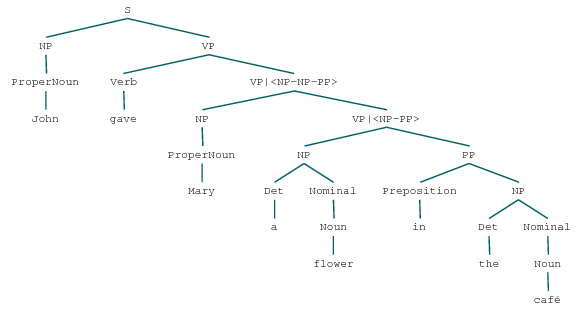

In [8]:
# Example call to tree.collapse_unary() to see how the names of nonterminals change
for tree in toy_parser.parse('John gave Mary a flower in the café'.split()):
    display(tree)
    tree.chomsky_normal_form()
    display(tree)

In [ ]:
def chomsky_normal_form(grammar):
    # Your solution here
    pass

### 3. CKY

Last time, we used NLTK's `ChartParser` to parse our grammar. In this exercise, we will replace it gradually with our own implementation of CKY.

#### 3.1 The parser class

First, create the `CKYParser` class. Imitate the interface of `ChartParser`. You don't need to look up the API: support only the functions we used thus far.

In [9]:
class CKYParser:
    def __init__(self, grammar):
        self.grammar = grammar
        
    def parse(self, sentence):
        pass

#### 3.2 Implement `parse()`

Implement the `parse()` method. You don't need to worry about the backpointers for now; just treat the cells of the matrix as a piece of paper and write strings to them. The functions should just return `True` if the sentence is grammatical and `False` if it isn't.

Hints:
- the easiest format for the matrix is probably a 2D `numpy` array with a `list` in each cell (we might have multiple candidates in a cell). Use `dtype=object`. Don't forget to initialize it.
- the `display()` method works on arrays and is a useful tool for debugging
- in 2D `numpy` arrays, rows are numbered from top to bottom. That takes care of the cell indexing part, because a cell represents the words `sentence[row:col+1]`.
- Implement just the main diagonal (lexical rules) first.
- Use the `grammar.productions()` function to get the list of production rules. To see how to use it, refer to
  - the `generate_sample` function above
  - `help(grammar.productions)`
- Note that in the production rules returned by `grammar.productions()`, terminals will be strings, and nonterminals instances of the `Nonterminal` object. You can get the actual symbol out of the latter with the `symbol()` method.

Use the CNF grammar below for development and the example sentence for testing.

In [10]:
import numpy
import itertools

class CKYParser:
    def __init__(self, grammar):
        self.grammar = grammar
        
    def parse(self, sentence):
        lens = len(sentence)
        matrix = numpy.empty((lens, lens), dtype=object)
        for row, col in itertools.product(range(lens), repeat=2):
            matrix[row, col] = []
        
        for col in range(matrix.shape[1]):
            for row in range(col, -1, -1):
                if col == row:
                    for prod in self.grammar.productions(rhs=sentence[col]):
                        matrix[row, col].append(prod.lhs())
                else:
                    scope = col - row + 1
                    for left in range(1, scope):
                        down = scope - left
                        for left_nt in matrix[row, col-left]:
                            for prod in self.grammar.productions(rhs=left_nt):
                                for right_nt in matrix[row + down, col]:
                                    if right_nt == prod.rhs()[1]:
                                        matrix[row, col].append(prod.lhs())
        return 'S' in [nt.symbol() for nt in matrix[0, lens - 1]]

In [11]:
grammar = nltk.CFG.fromstring("""
S -> NP VP | ProperNoun VP | NP Verb | ProperNoun Verb
NP -> Det Nominal | Det Noun
Nominal -> Nominal Noun | Noun Noun
VP -> Verb NP | Verb ProperNoun
Det -> 'the'
Noun -> 'dog' | 'bit'
ProperNoun -> 'John'
Verb -> 'bit'
""")

parser = CKYParser(grammar)
print('Sentence is grammatical:', parser.parse('the dog bit John'.split()))

Sentence is grammatical: True


#### 3.3 The full monty

Modify `parse()` so that it returns the parse tree. In the original CKY algorithm, each nonterminal maintains backpointers to its children. Instead, we will build the `Tree` object directly (which is little more that a label and a list of backpointers, really).

There are two things you should do here:
1. When filling a cell: instead of adding the name of the nonterminal to the list in the cell, add a `Tree` with the name as label and the right children. The constructor's signature is `Tree(node, children)`, where the latter is a `list`.
2. Change your method to be a _generator_: yield all `Tree`s from the top right cell whose label is `S`.

Don't forget that `Tree.label()`s are strings, so if you want to look for them in `grammar.productions()`, enclose them into a `Nonterminal` object.

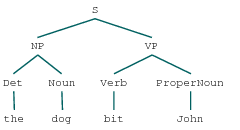

In [12]:
class CKYParser:
    def __init__(self, grammar):
        self.grammar = grammar
        
    def parse(self, sentence):
        lens = len(sentence)
        matrix = numpy.empty((lens, lens), dtype=object)
        for row, col in itertools.product(range(lens), repeat=2):
            matrix[row, col] = []
        
        for col in range(matrix.shape[1]):
            for row in range(col, -1, -1):
                if col == row:
                    for prod in self.grammar.productions(rhs=sentence[col]):
                        matrix[row, col].append(Tree(prod.lhs().symbol(), [sentence[col]]))
                else:
                    scope = col - row + 1
                    for left in range(1, scope):
                        down = scope - left
                        for left_nt in matrix[row, col-left]:
                            for prod in self.grammar.productions(rhs=Nonterminal(left_nt.label())):
                                for right_nt in matrix[row + down, col]:
                                    if right_nt.label() == prod.rhs()[1].symbol():
                                        matrix[row, col].append(Tree(prod.lhs().symbol(), [left_nt, right_nt]))
        for tree in matrix[0, lens - 1]:
            if tree.label() == 'S':
                yield tree

parser = CKYParser(grammar)
for tree in parser.parse('the dog bit John'.split()):
    display(tree)

#### 3.4 Testing

Test your algorithm on the arithmetic example. Make sure it returns the same trees as `ChartParser`.